# Tarea-Proyecto 1
## Alumno: Cruz Cortés Diego

Descripción del Dataset


[dataset de Kaggle](https://www.kaggle.com/datasets/htagholdings/property-sales/data): We have accumulated property sales data for the 2007-2019 period for one specific region. The data contains sales prices for houses and units with 1,2,3,4,5 bedrooms. These are the cross-depended variables. The chart illustrates these variables for houses.

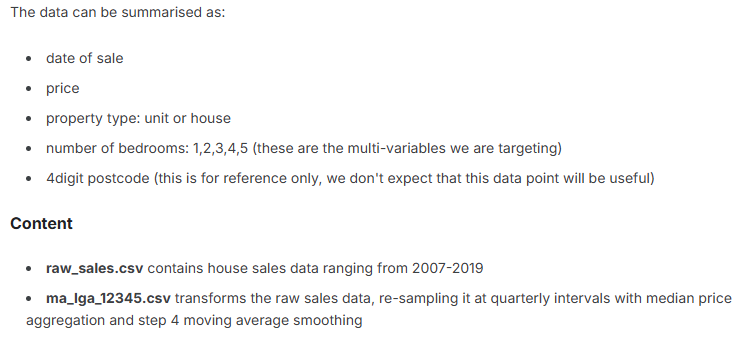



In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import plotly.graph_objects as go


In [3]:
# Cargar los datos de vivienda
housing_data = pd.read_csv('ma_lga_12345.csv')

EDA

In [27]:
housing_data.head()

,MA,type,bedrooms
saledate,,,
2007-03-31,421291,house,3
2007-03-31,548969,house,4
2007-06-30,421291,house,3
2007-06-30,368817,unit,2
2007-06-30,548969,house,4


In [28]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 347 entries, 2007-03-31 to 2019-09-30
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MA        347 non-null    int64 
 1   type      347 non-null    object
 2   bedrooms  347 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 10.8+ KB


In [29]:
housing_data.describe()

,MA,bedrooms
count,3.470000e+02,347.000000
mean,5.481320e+05,2.867435
std,1.701934e+05,1.239875
min,3.167510e+05,1.000000
25%,4.277395e+05,2.000000
50%,5.077440e+05,3.000000
75%,6.275155e+05,4.000000
max,1.017752e+06,5.000000


In [30]:
#verifiquemos si hay valores NaN
housing_data.isnull().sum()

,0
MA,0
type,0
bedrooms,0


In [35]:
# Visualización con plotly para interactividad
fig = go.Figure()

for prop_type in housing_data['type'].unique():
    for bedroom in housing_data['bedrooms'].unique():
        subset = housing_data[(housing_data['type'] == prop_type) & (housing_data['bedrooms'] == bedroom)]
        if not subset.empty:
            fig.add_trace(go.Scatter(
                x=subset.index,
                y=subset['MA'],
                mode='lines',
                name=f'{prop_type} - {bedroom} bedrooms'
            ))
fig.update_layout(
    title='Precios inmobiliarios por tipo y número de habitaciones',
    xaxis_title='Fecha',
    yaxis_title='Precio (MA)',
    legend_title='Tipo de propiedad - Habitaciones',
    template='plotly_white'
)

fig.show()

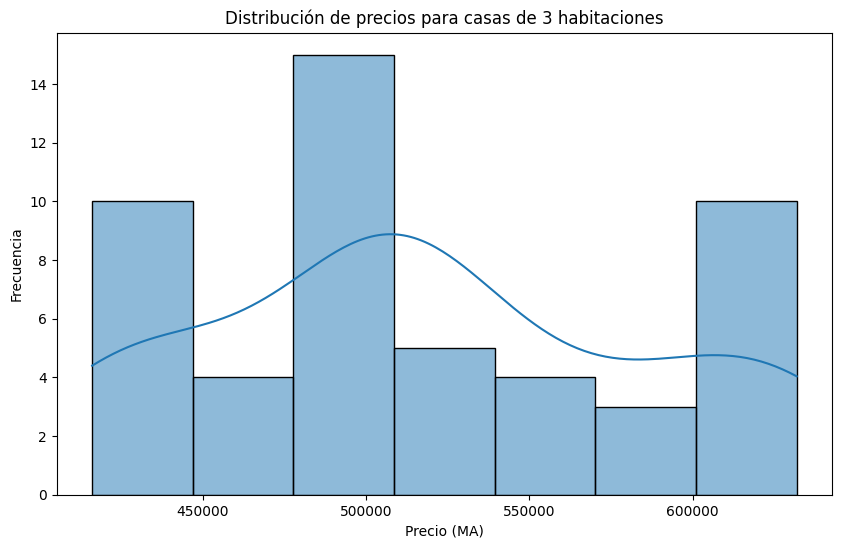

In [37]:
import seaborn as sns
# Análisis de estacionalidad y distribución
# Seleccionemos una categoría específica para el análisis detallado
house_3br = housing_data[(housing_data['type'] == 'house') & (housing_data['bedrooms'] == 3)]

# Análisis de la distribución de precios
plt.figure(figsize=(10, 6))
sns.histplot(house_3br['MA'], kde=True)
plt.title('Distribución de precios para casas de 3 habitaciones')
plt.xlabel('Precio (MA)')
plt.ylabel('Frecuencia')
plt.show()

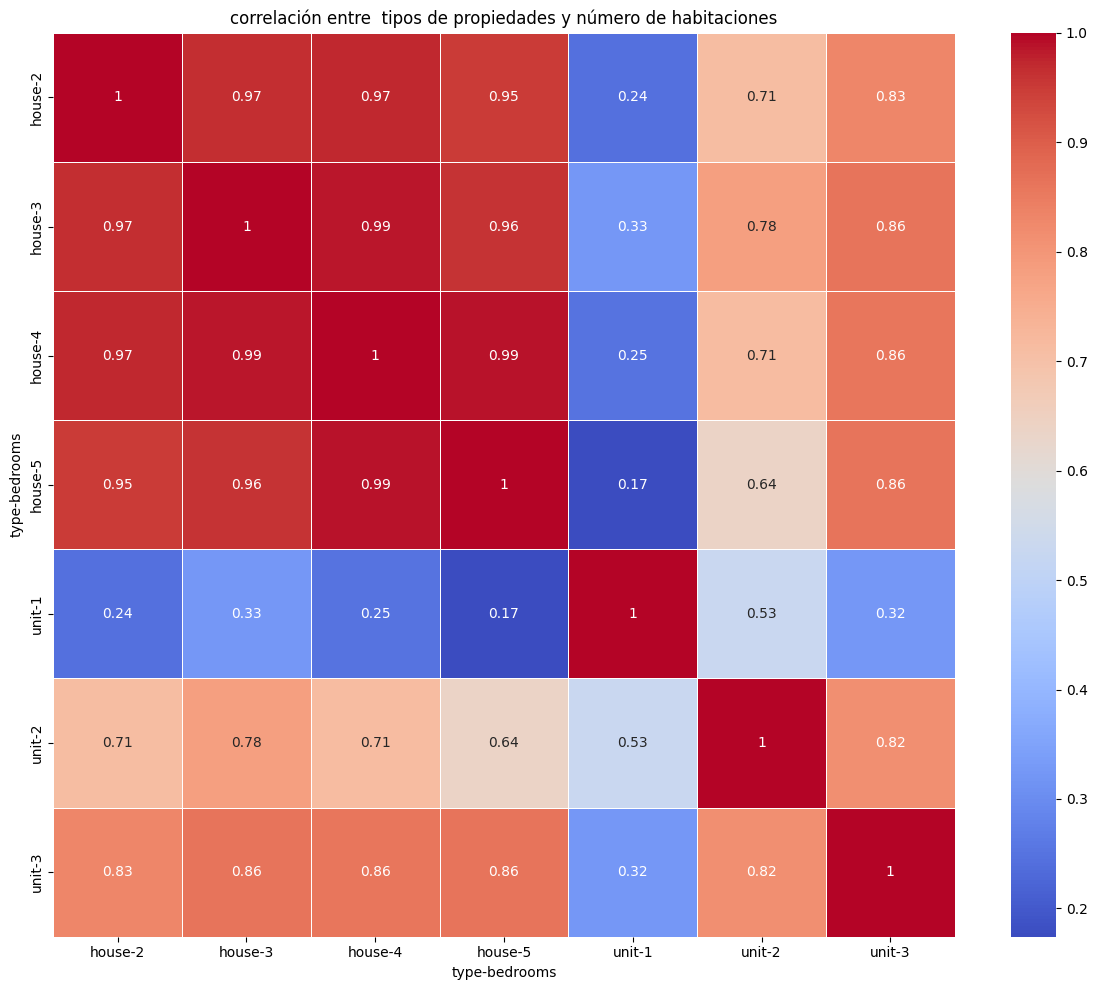

In [38]:
# Matriz de correlación
correlation = housing_data.pivot_table(index='saledate', columns=['type', 'bedrooms'], values='MA')
plt.figure(figsize=(12, 10))
sns.heatmap(correlation.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('correlación entre  tipos de propiedades y número de habitaciones')
plt.tight_layout()
plt.show()

In [4]:
# pasamos columna de fecha a formato datetime
housing_data['saledate'] = pd.to_datetime(housing_data['saledate'], format='%d/%m/%Y')

# Establecemos la fecha como índice
housing_data.set_index('saledate', inplace=True)

# el índice por fecha
housing_data.sort_index(inplace=True)

#  vamos a centrarnos en casas de 3 dormitorios
train_data = housing_data[(housing_data['type'] == 'house') & (housing_data['bedrooms'] == 3)]

train_data = train_data[['MA']]

In [5]:
# No hay necesidad de limpieza ya que los datos están completos, pero podemos incluir el código por si acaso
imputer = SimpleImputer(strategy='mean')
train_data = pd.DataFrame(imputer.fit_transform(train_data), columns=train_data.columns, index=train_data.index)

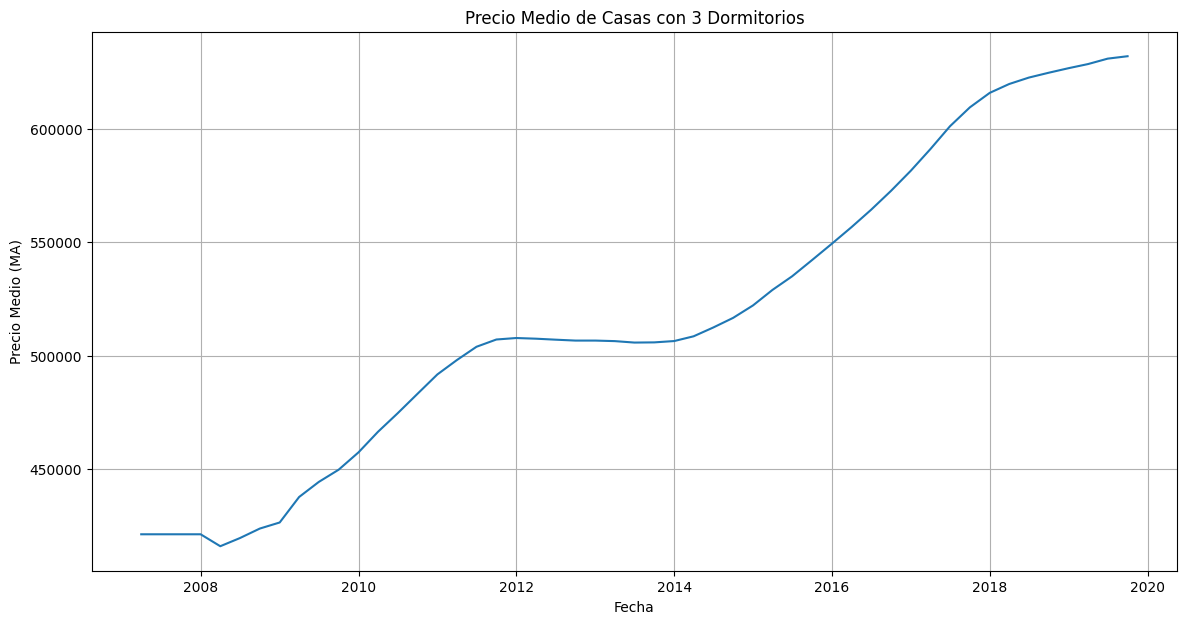

In [6]:
# datos de entrenamiento
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['MA'])
plt.title('Precio Medio de Casas con 3 Dormitorios')
plt.xlabel('Fecha')
plt.ylabel('Precio Medio (MA)')
plt.grid(True)
plt.show()

In [7]:
# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)

In [8]:
#secuencias temporales para entrenamiento
def create_dataset(dataset, look_back=12):  # 12 meses como ventana de tiempo
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [9]:
#Usaremos 12 meses como ventana de tiempo para predecir el siguiente mes
X_train, y_train = create_dataset(train_scaled, 12)

In [10]:
# LSTM
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, validation_split=0.2)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - loss: 0.2818 - val_loss: 0.5162
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1281 - val_loss: 0.1564
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0257 - val_loss: 0.0068
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0213 - val_loss: 0.0362
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0244 - val_loss: 0.0071
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0065 - val_loss: 0.0527
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0160 - val_loss: 0.0621
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0148 - val_loss: 0.0349
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0112 - val_loss: 0.0080
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0078 - val_loss: 0.0026
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0074 - val_loss: 0.0034
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0083 - val_l

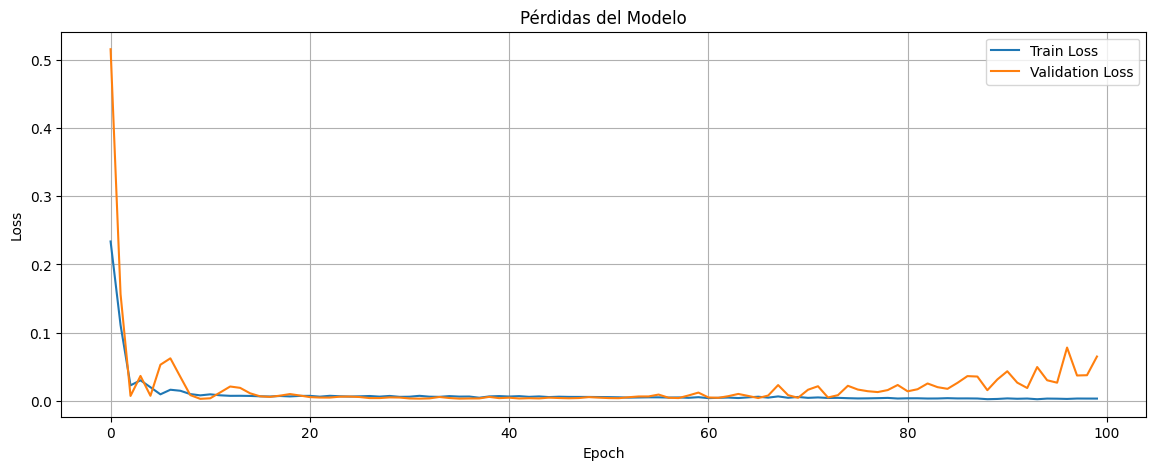

In [13]:
# pérdidas durante el entrenamiento
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdidas del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# predicciones en el conjunto de entrenamiento
train_predict = model.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


In [15]:
# Toca invertir el escalado para obtener los precios reales
train_predict_full = np.zeros((len(train_predict), train_data.shape[1]))
train_predict_full[:, 0] = train_predict[:, 0]
train_predict = scaler.inverse_transform(train_predict_full)[:, 0]

In [16]:
# Preparacion de los datos reales para comparación
real_y = scaler.inverse_transform(train_scaled)[12:len(train_predict)+12, 0]

In [17]:
# Creacion de los índices para graficar
train_predict_index = train_data.index[12:len(train_predict)+12]

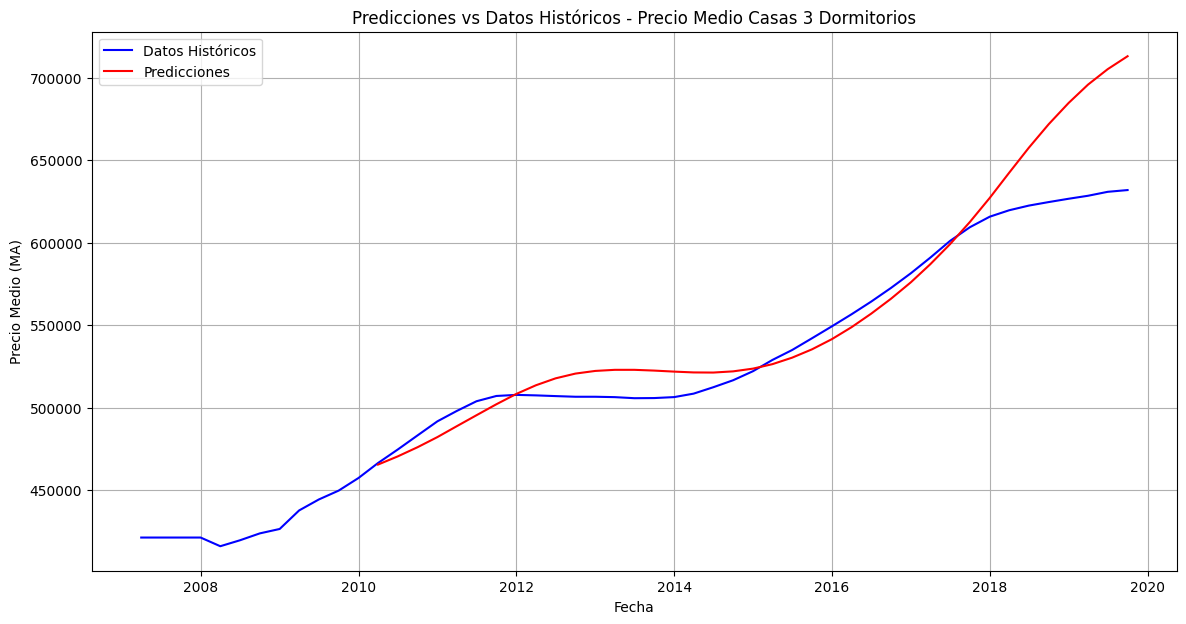

In [18]:
# resultados de entrenamiento
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['MA'], label='Datos Históricos', color='blue')
plt.plot(train_predict_index, train_predict, label='Predicciones', color='red')
plt.title('Predicciones vs Datos Históricos - Precio Medio Casas 3 Dormitorios')
plt.xlabel('Fecha')
plt.ylabel('Precio Medio (MA)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# métricas de rendimiento
r2 = r2_score(real_y, train_predict)
mse = np.mean((real_y - train_predict)**2)
print(f'R-squared: {r2:.4f}')
print(f'MSE: {mse:.2f}')

R-squared: 0.7424
MSE: 686439996.80


In [39]:
# Predicción para los próximos 6 meses
def forecast_future(model, last_sequence, n_future=6):
    """
    Predice los próximos n_future valores basados en la última secuencia conocida
    """
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_future):
        current_pred = model.predict(current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1]))

        future_predictions.append(current_pred[0, 0])

        new_value = np.zeros((1, current_sequence.shape[1]))
        new_value[0, 0] = current_pred[0, 0]
        current_sequence = np.vstack([current_sequence[1:], new_value])

    return np.array(future_predictions)

In [21]:
# última secuencia conocida
last_sequence = train_scaled[-12:]

# Predeccion de los próximos 6 meses
future_scaled = forecast_future(model, last_sequence, 6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [22]:
# escalado para obtener los precios reales
future_full = np.zeros((len(future_scaled), train_data.shape[1]))
future_full[:, 0] = future_scaled
future_predictions = scaler.inverse_transform(future_full)[:, 0]

# fechas futuras
last_date = train_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='M')

<ipython-input-22-3e477f94b166>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='M')


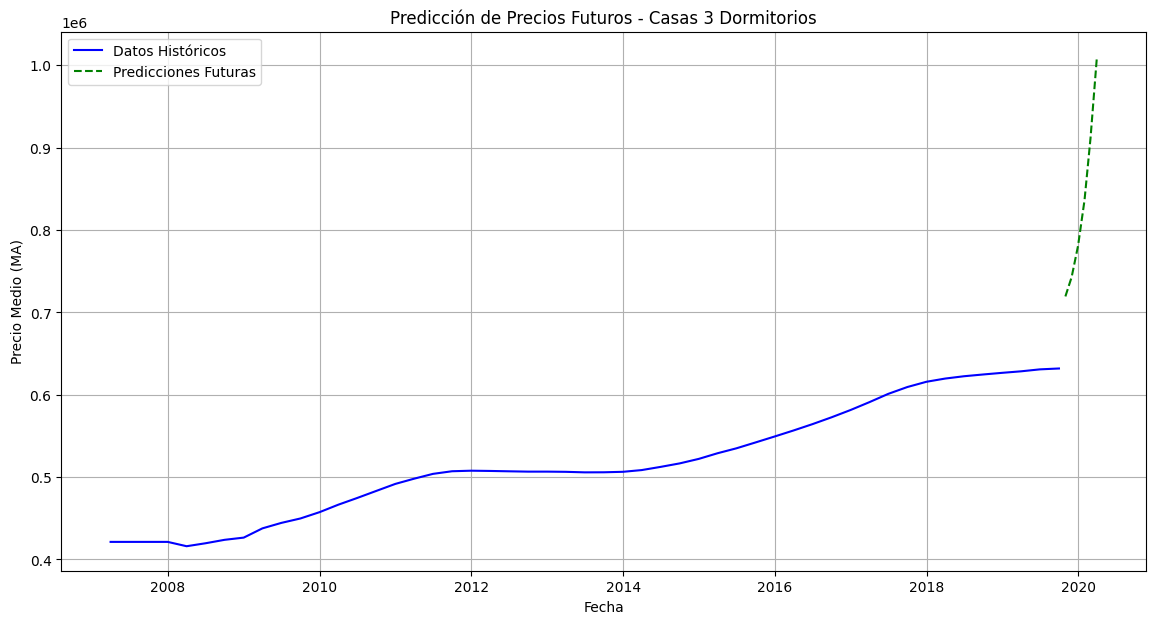

In [23]:
# Toca graficar las predicciones futuras
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['MA'], label='Datos Históricos', color='blue')
plt.plot(future_dates, future_predictions, label='Predicciones Futuras', color='green', linestyle='--')
plt.title('Predicción de Precios Futuros - Casas 3 Dormitorios')
plt.xlabel('Fecha')
plt.ylabel('Precio Medio (MA)')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
#  predicciones futuras
future_df = pd.DataFrame({'Fecha': future_dates, 'Precio Predicción': future_predictions})
print("Predicciones para los próximos 6 meses:")
print(future_df)

Predicciones para los próximos 6 meses:
       Fecha  Precio Predicción
0 2019-10-31       7.193872e+05
1 2019-11-30       7.427662e+05
2 2019-12-31       7.809041e+05
3 2020-01-31       8.360106e+05
4 2020-02-29       9.116433e+05
5 2020-03-31       1.011099e+06


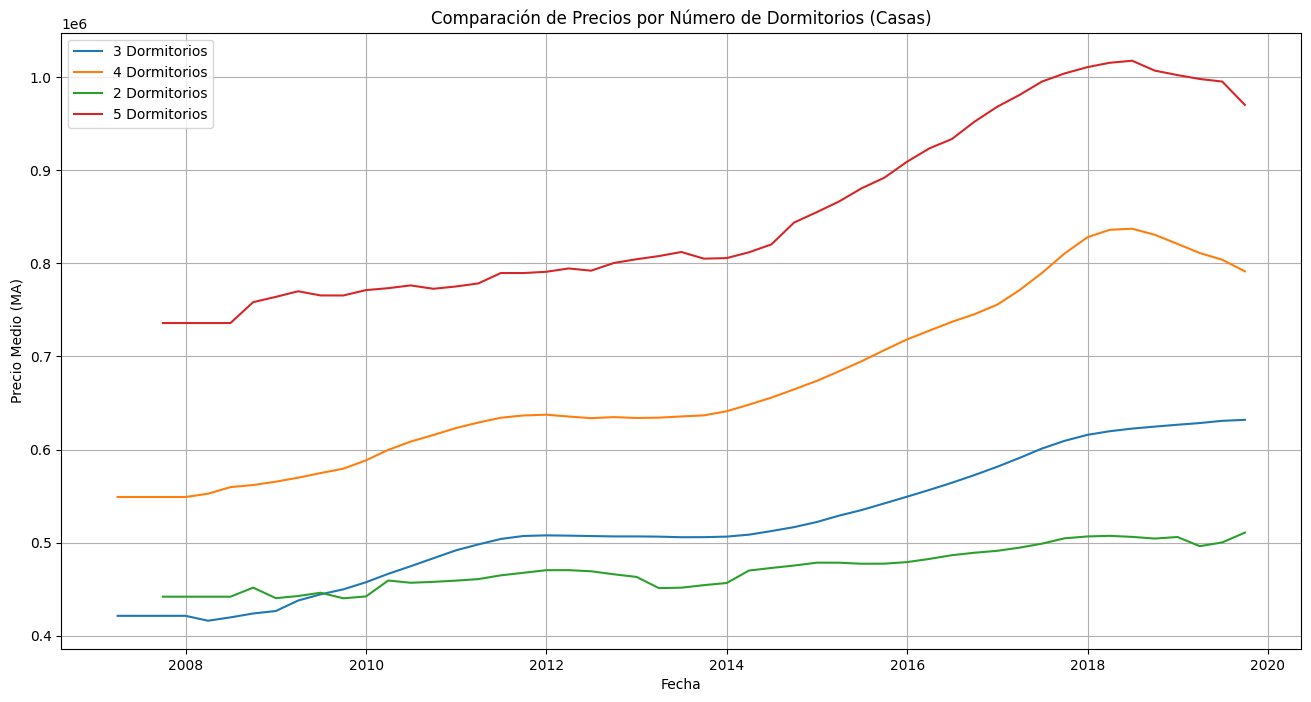

In [25]:
# Podemos extender este análisis para comparar diferentes tipos de propiedades
plt.figure(figsize=(16, 8))
for bedrooms in housing_data[housing_data['type'] == 'house']['bedrooms'].unique():
    data = housing_data[(housing_data['type'] == 'house') & (housing_data['bedrooms'] == bedrooms)]
    plt.plot(data.index, data['MA'], label=f'{bedrooms} Dormitorios')
    plt.title('Comparación de Precios por Número de Dormitorios (Casas)')
plt.xlabel('Fecha')
plt.ylabel('Precio Medio (MA)')
plt.legend()
plt.grid(True)
plt.show()

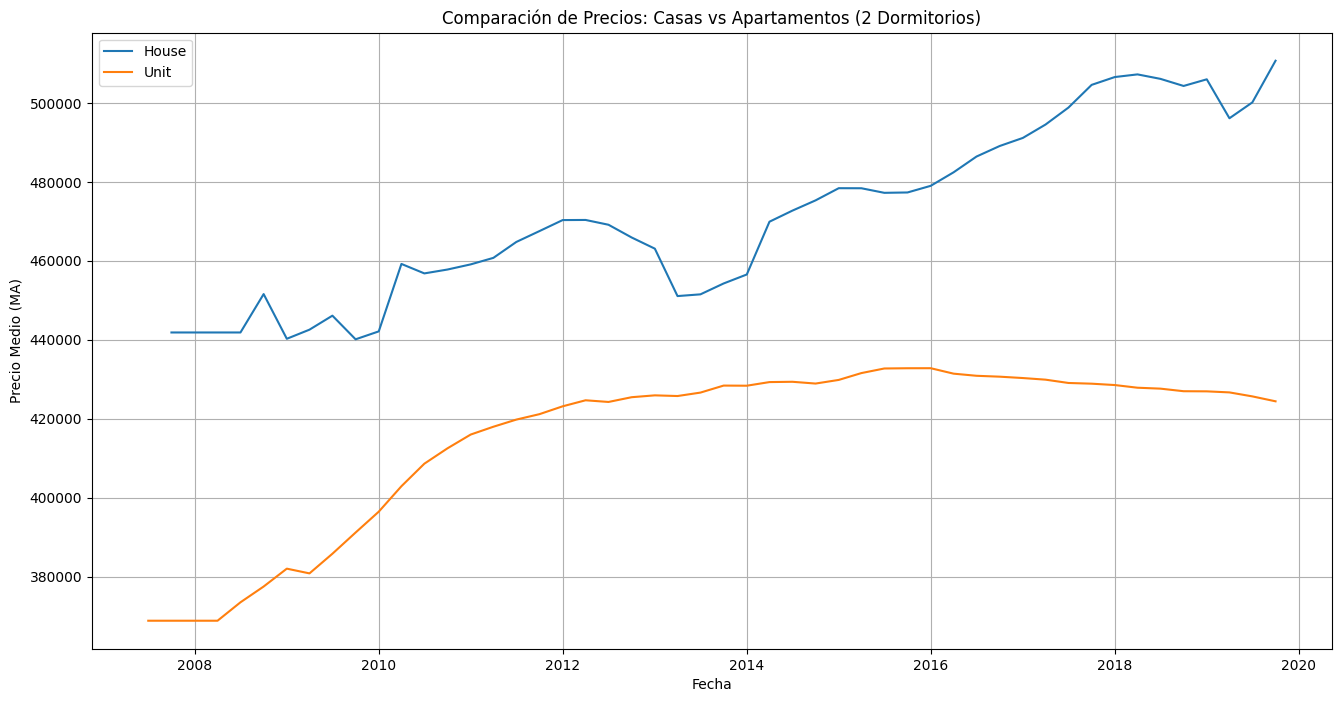

In [26]:
# Comparación entre casas y apartamentos
plt.figure(figsize=(16, 8))
for prop_type in housing_data['type'].unique():
    # aqui tomamos solo propiedades de 2 dormitorios para comparar equitativamente
    data = housing_data[(housing_data['type'] == prop_type) & (housing_data['bedrooms'] == 2)]
    plt.plot(data.index, data['MA'], label=f'{prop_type.capitalize()}')

plt.title('Comparación de Precios: Casas vs Apartamentos (2 Dormitorios)')
plt.xlabel('Fecha')
plt.ylabel('Precio Medio (MA)')
plt.legend()
plt.grid(True)
plt.show()